In [ ]:
!pip install yfinance tensorflow matplotlib scikit-learn



In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


/tmp/ipython-input-3157729232.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261051  24.729274  23.821675  24.718178  212818400
2015-01-05  23.577572  24.110148  23.391171  24.030261  257142000
2015-01-06  23.579792  23.839422  23.218083  23.641926  263188400
2015-01-07  23.910433  24.010290  23.677430  23.788384  160423600
2015-01-08  24.829121  24.886817  24.121238  24.238850  237458000


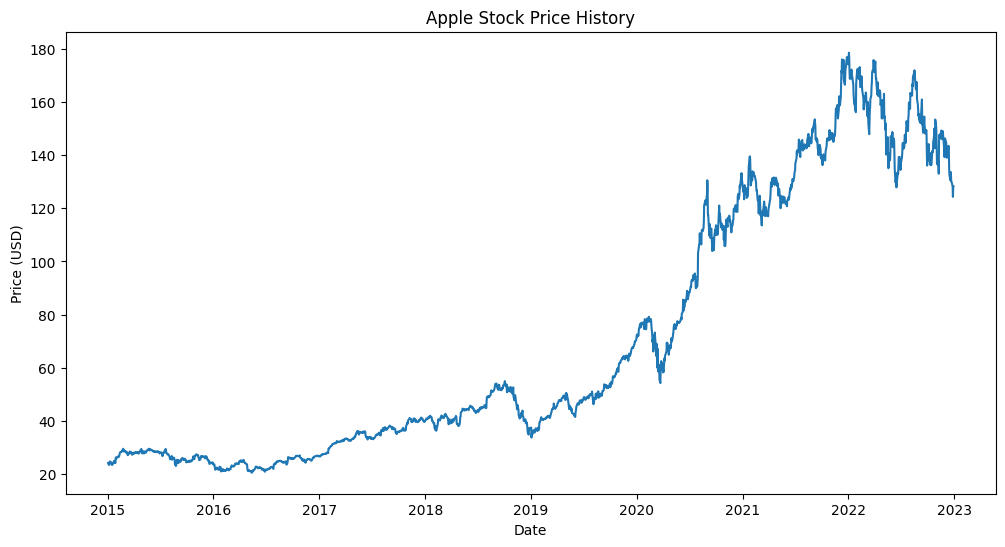

In [ ]:
# Download data
data = yf.download('AAPL', start='2015-01-01', end='2023-01-01')

# Show data
print(data.head())

# Plot closing price
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title("Apple Stock Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()


In [ ]:
# Use only closing price
close_data = data['Close'].values
close_data = close_data.reshape(-1,1)

# Scale values (0 to 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

# Create training data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size-60:]

# Helper function
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=10)



Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0200
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0013
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 8.6301e-04
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0010
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 7.4732e-04
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7.0269e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 9.4236e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.4357e-04
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 5.4295e-04
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 6.4312e-04


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


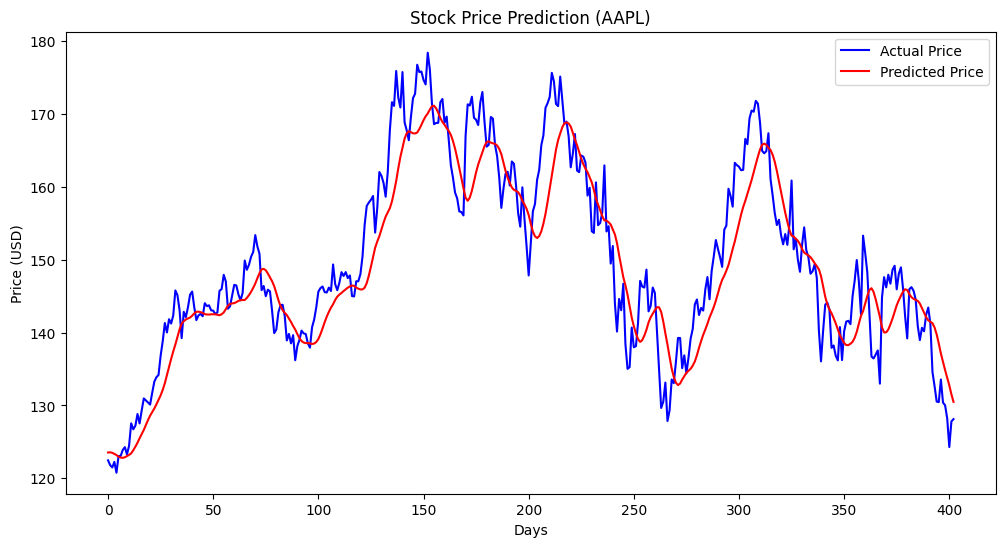

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(real_prices, color="blue", label="Actual Price")
plt.plot(predictions, color="red", label="Predicted Price")
plt.title("Stock Price Prediction (AAPL)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [ ]:
!pip install yfinance tensorflow matplotlib scikit-learn gradio


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import gradio as gr


In [ ]:
def predict_stock(ticker="AAPL"):
    # Download stock data
    data = yf.download(ticker, start='2015-01-01', end='2023-01-01')

    # Prepare data
    close_data = data['Close'].values.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(close_data)

    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size-60:]

    def create_dataset(dataset, time_step=60):
        X, y = [], []
        for i in range(time_step, len(dataset)):
            X.append(dataset[i-time_step:i, 0])
            y.append(dataset[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_dataset(train_data)
    X_test, y_test = create_dataset(test_data)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build LSTM Model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

    # Plot results
    plt.figure(figsize=(10,5))
    plt.plot(real_prices, color="blue", label="Actual Price")
    plt.plot(predictions, color="red", label="Predicted Price")
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel("Days")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.savefig("result.png")
    plt.close()

    return "result.png"


In [ ]:
iface = gr.Interface(
    fn=predict_stock,
    inputs=gr.Textbox(label="Enter Stock Ticker (e.g., AAPL, TSLA, GOOG)"),
    outputs=gr.Image(label="Prediction Graph"),
    title="📈 Stock Price Predictor",
    description="Enter a stock ticker symbol to see predicted vs actual stock prices."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f22ada9e613dcb5e02.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
